#### Documentation notes on this notebook:

##### Purpose
- Used as an exploratory notebook to look at both API and human transcriptions, potential Squad Score formulas, and correlations with story rankings and textstat packages
- Training data: 167 stories
- Generate a pickled scaler from training data for use in production

##### Outcomes
- Ultimately, API transcriptions used over human transcriptions to generate scaler and formula for production, as it's closest to what will actually be seen in production.
- MinMaxScaler was selected over StandardScaler to maintain positive score values
- More features are explored in this notebook than were included in the Squad Score formula
- Initial Squad Score includes only features generated with Python & Pandas that represent either features used in validated writing complexity metrics OR features requested by stakeholder, AND are versions of the feature that are impacted as minimally as possible by inevitable errors in spelling, handwriting, and transcription. 
- Weights are initialized at 1 for each feature.
- This Squad Score results in a -.60 correlation coefficient with provided stakeholder rankings.

##### Future Considerations
- Scaler should be re-fit with any newly provided training data
- Major room for growth in this formula is to improve the weights to something other than 1s. This choice was made due to lack of labels, and reluctance to create an over-fit formula, but if different techniques are available or labels are provided, the weights should be adjusted accordingly to improve the formula.

In [1]:
import glob

import joblib
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import textstat

from nltk.tokenize import PunktSentenceTokenizer
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Uncomment to download nltk modules
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

In [3]:
# Import API-transcribed stories
path = "../../api_transcribed_stories.csv"

api_t = pd.read_csv(
            path, 
            usecols=[1,2],
            header=0,
            names=["story_id", "transcription"],
            dtype=str
            )

In [4]:
# Compile human-transcribed stories for comparison

root = "../../Stories Dataset/Transcribed Stories/"

transcriptions = []

for file in glob.glob(root + '**/**/Story*[3000-5999]*'):
    with open((file), 'r') as file:
        story_id = file.name[-4:]
        transcription = file.read().replace('\n', ' ')
        transcriptions.append((story_id, transcription))

In [5]:
# Generate dataframe of transcriptions
cols = ['story_id', 'transcription']
human_t = pd.DataFrame(transcriptions, columns=cols)

In [6]:
def calc_metrics(df):
    """ 
    Cleans transcriptions and adds various metrics as columns.
    
    Features included:
    - Grade level
    - Length of story (in characters)
    - Average word length (in chars)
    - Number of quotation marks
    - Number of unique words
    - Number of adjectives
    - Percentage of complex words
    
    Note that code generating proportional features is commented out, as correlation
    to rankings sharply decreased with this change in feature quality.
    """
    # Avoid SettingWithCopy error
    df = df.copy()
    
    # Clean potential transcription errors

    # Strip leading or tailing spaces and integers 
    df["transcription"] = df["transcription"].str.strip().str.strip('/-0123456789')
    
    # Ensure all commas and periods are followed by a space
    df["transcription"] = df["transcription"].str.replace(".", ". ").str.replace(",", ", ")
    
    # Remove any instances of multiple spaces
    df["transcription"] = df["transcription"].str.split().str.join(" ")
    
    
    # Add metrics
    
    # Grade level
    df["grade_level"] = df["story_id"].str[0].astype(int)

    # Length of story
    df["story_length"] = df["transcription"].str.len()
    
    # Average word length
    word_count = (df["transcription"].str.split()).str.len()
    df["avg_word_len"] = df["story_length"] / word_count
    
    # Number of quotation marks
    # quote_count = df["transcription"].str.count('"')
    # df["quotes_ratio"] = quote_count / df["story_length"]
    df["quotes_num"] = df["transcription"].str.count('"') 
    
    # Number of unique words, over 2 characters    
    def over_two_chars(transcription):
        """Returns number of unique 2+ char words in transcription."""
        word_list = transcription.split()
        word_set = set()
        for x in word_list:
            if len(x) > 2: 
                word_set.add(x)
        return len(word_set)
    
    # unique_words_count = df["transcription"].apply(over_two_chars)
    # df["unique_word_ratio"] = unique_words_count / df["story_length"]
    df["unique_words_num"] = df["transcription"].apply(over_two_chars)
    
    # Number of adjectives
    def num_adj(transcription):
        """Returns number of adjectives in transcription."""
        tokens = nltk.word_tokenize(transcription)
        pos = nltk.pos_tag(tokens)
        adj_count = 1
        for word in pos:
            if word[1] == 'JJ':
                adj_count += 1
        return adj_count
    
    # adj_count = df["transcription"].apply(num_adj)
    # df["adj_ratio"] = adj_count / df["story_length"]
    df["adj_num"] = df["transcription"].apply(num_adj)
    
    # Percentage of complex words, based on textstat's automated function
    # Compares to list of 3000 most commonuly used English words
    # Number of words in story that are not on that list are considered "complex"
    # Note: prone to errors, may need to be iterated on to be production-grade
    num_complex_words = df["transcription"].apply(textstat.difficult_words)
    df["percent_complex_words"] = num_complex_words / word_count * 100
    
    return df

In [7]:
# Calculate both API and human transcription metrics
human_metrics = calc_metrics(human_t)
api_metrics = calc_metrics(api_t)

In [8]:
print(human_metrics.shape)
human_metrics.head(1)

(167, 9)


,story_id,transcription,grade_level,story_length,avg_word_len,quotes_num,unique_words_num,adj_num,percent_complex_words
0,3132,Page 1 Once there was a little cheatah and the...,3,1378,5.122677,14,136,14,4.460967


In [9]:
print(api_metrics.shape)
api_metrics.head(1)

(167, 9)


,story_id,transcription,grade_level,story_length,avg_word_len,quotes_num,unique_words_num,adj_num,percent_complex_words
0,3132,Page. I 3132 Once there was a little cheatah a...,3,1375,5.092593,6,138,15,4.814815


In [10]:
# Look at output of complex words feature -- note how many are not real words
sample_transcription = api_metrics.iloc[0,1]
textstat.difficult_words_list(sample_transcription)

['usall',
 'bacle',
 'friendo',
 'hunting',
 "lion's",
 'familys',
 'bylans',
 'dylan',
 'thier',
 'dylanto',
 'parents',
 'minutes',
 'dylans']

In [11]:
# Compare to full transcription
# Decision was made to keep compplex_words feature out of Squad Score for 
# unreliability in the limitations of this product
sample_transcription

'Page. I 3132 Once there was a little cheatah and the cheatah had a best friend lion the cheatah\'s name was paws and the lion\'s name was Dylan they always played with each other after they went hunting Dylan went to play with Paws after hunting with pack, and Paws wont to play after hunting with his mom. They always met up near the same rock arth the same lake, they would talk and have water fights here is what the talked about your parents and my pack might have a fight" said Dylan "We both don\'t want that to happen we might have to fight against each other, said Paws After afew minutes it was time for them bacle to their family. Next morning they saw there family having a fight, Dylans family, won and Paus mom was hert. At thier usall he meeting time they talked aboutit. "My mom got hert, It\'s not fair" said Paws I think the best way to fix this is to tell are family we are friendo" said Dylan "I think your right said Paws. So after there talk time and water fight they went back 

In [49]:
# Change this variable to alter which features are included in scaler and Squad Score
scaled_features = ["story_length", "avg_word_len", "quotes_num", "unique_words_num"]

In [13]:
scaler_h = MinMaxScaler()
scaler_h.fit(human_metrics[scaled_features])

MinMaxScaler()

In [14]:
scaler_api = MinMaxScaler()
scaler_api.fit(api_metrics[scaled_features])

# Uncomment line below to pickle scaler for future use
# joblib.dump(scaler_api, "../project/app/utils/complexity/MinMaxScaler.pkl")

MinMaxScaler()

In [15]:
def scale_row(row, transcription_source):
    """
    Takes one row and scales it according to corresponding scaler.
    
    This function is integrated into the squad_score function
    
    row: full row of dataframe or a list
    transcription_source (str): "api" or "human" based on source of transcription
    """
    if transcription_source == "api":
        scaler = scaler_api
    elif transcription_source == "human":
        scaler = scaler_h
    else:
        raise ValueError("Not a valid transcription source. Valid options: 'api' or 'human'.")
    
    return scaler.transform([row[scaled_features]])

In [16]:
# Test on API transcription sample
test_row = api_metrics.loc[0,scaled_features]
scale_row(test_row, "api")

array([[0.36490589, 0.45999584, 0.13953488, 0.34146341]])

In [17]:
# Test on human transcription sample
test_row = human_metrics.loc[0,scaled_features]
scale_row(test_row, "human")

array([[0.34876246, 0.47520045, 0.16666667, 0.35472973]])

In [18]:
# Check test_row
test_row

story_length           1378
avg_word_len        5.12268
quotes_num               14
unique_words_num        136
Name: 0, dtype: object

In [19]:
def squad_score(row, transcription_source):
    """
    Scales, weights, and adds all metrics for a given transcription.
    
    Scales according to transcription source (see scale_row function).
    Weights according to presribed weights used only for Story Squad analysis.
    
    row: full row of dataframe or a list
    transcription_source (str): "api" or "human" based on source of transcription
    """
    
    # Instantiate weights
    weights = {"grade_level": 0,
              "story_length": 1,
              "avg_word_len": 1,
              "quotes_number": 1,
               "unique_words": 1,
               "adj_num": 0,
              "percent_complex_words": 0}
    
    # Scale needed metrics
    scaled = scale_row(row, transcription_source)[0]
    
    # Generate scaler to create desired output range
    range_scaler = 30
    
    # Weight values
    # gl = weights["grade_level"] * row[2] * range_scaler
    sl = weights["story_length"] * scaled[0] * range_scaler
    awl = weights["avg_word_len"] * scaled[1] * range_scaler
    qn = weights["quotes_number"] * scaled[2] * range_scaler
    uw = weights["unique_words"] * scaled[3] * range_scaler
    # an = weights["adj_num"] * scaled[4] * range_scaler
    # pcw = weights["percent_complex_words"] * scaled[5] * range_scaler
    
    # Add all values
    s_score = sl + awl + qn + uw
    
    return s_score

In [20]:
# Calculate Squad Scores for all transcriptions and generate new DFs
h_squad_score = human_metrics[["story_id"]].copy()
h_squad_score["squad_score"] = human_metrics.apply(lambda x: squad_score(x, "human"), axis=1)

api_squad_score = api_metrics[["story_id"]].copy()
api_squad_score["squad_score"] = api_metrics.apply(lambda x: squad_score(x, "api"), axis=1)

In [21]:
# Check head
api_squad_score.head(1)

,story_id,squad_score
0,3132,39.177001


In [22]:
h_squad_score.describe()

,squad_score
count,167.000000
mean,40.671110
std,15.889151
min,0.000000
25%,29.310081
50%,38.685482
75%,50.167152
max,94.558085


In [23]:
api_squad_score.describe()

,squad_score
count,167.000000
mean,39.918599
std,15.807567
min,1.668999
25%,28.439521
50%,36.818549
75%,49.477881
max,89.110260


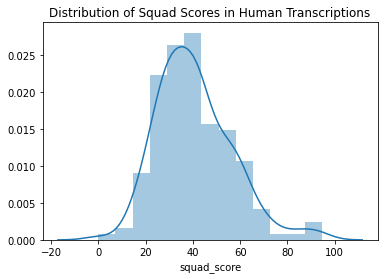

In [24]:
# Visualize distribution of Squad Score for human transcriptions
ax = sns.distplot(h_squad_score["squad_score"])
plt.title("Distribution of Squad Scores in Human Transcriptions")
plt.show()

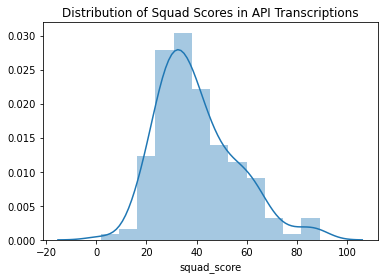

In [25]:
# Visualize distribution of Squad Score for API transcriptions
# Note that API distribution is similar to human distribution
ax = sns.distplot(api_squad_score["squad_score"])
plt.title("Distribution of Squad Scores in API Transcriptions")
plt.show()

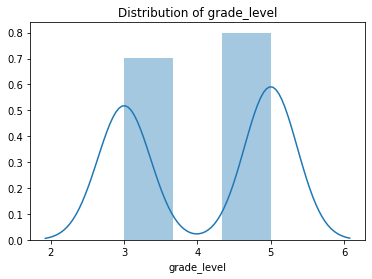

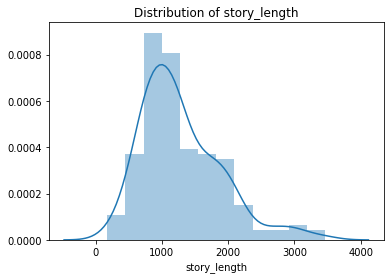

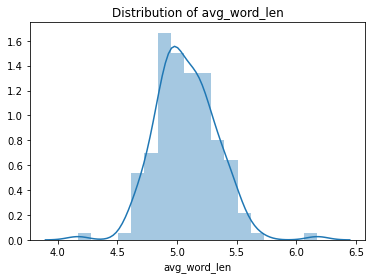

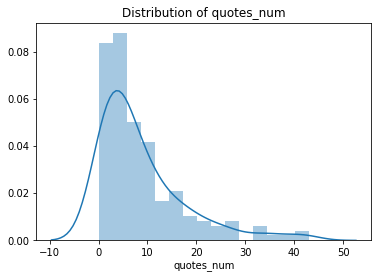

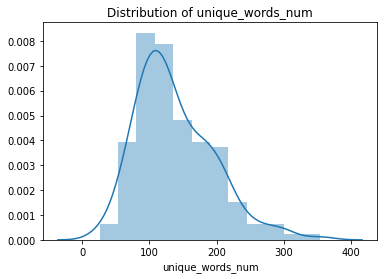

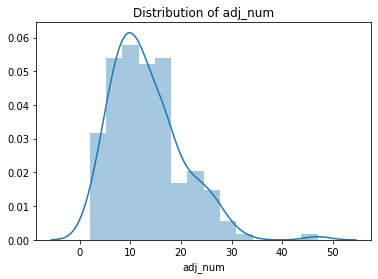

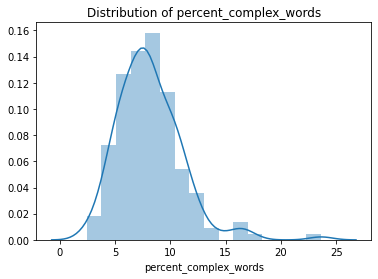

In [26]:
# Visualize distribtutions for all potential features of API

def feature_distplots(df):
    """Outputs distplots of all features in provided df."""
    for col, data in df.iteritems():
        ax = sns.distplot(df[col])
        plt.title(f"Distribution of {col}")
        plt.show()

feature_distplots(api_metrics.iloc[:,2:])

In [27]:
# Create dictionary of hand rankings of 25 stories, provided by stakeholder
rankings = {"3130": 1,  # key == Story ID, value == rank
             "3112": 2,
             "5109": 3,
             "3118": 4,
             "3122": 5,
             "3108": 6,
             "5108": 7,
             "3121": 8,
             "3101": 9,
             "3128": 10,
             "3106": 11,
             "3126": 12,
             "3129": 13,
             "3105": 14,
             "5104": 15,
             "5101": 16,
             "5103": 17,
             "3125": 18,
             "3111": 19,
             "3119": 20,
             "3110": 21,
             "3117": 22,
             "3127": 23,
             "3131": 24,
             "3120": 25} 

In [28]:
# Subset dataframe for ranked human transcriptions
ranked_stories_h = human_metrics[human_metrics["story_id"].isin(rankings.keys())].reset_index(drop=True)
# Add rankings
ranked_stories_h["ranking"] = ranked_stories_h["story_id"].apply(lambda x: rankings[x])

# Subset dataframe for ranked API transcriptions
ranked_stories_api = api_metrics[api_metrics["story_id"].isin(rankings.keys())].reset_index(drop=True)
# Add rankings
ranked_stories_api["ranking"] = ranked_stories_api["story_id"].apply(lambda x: rankings[x])

In [29]:
# Add Squad Score based on squad_score function
ranked_stories_h["squad_score"] = ranked_stories_h.iloc[:,:-1].apply(lambda x: squad_score(x, "human"), axis=1)
# Add the rank based on the squad score
ranked_stories_h["squad_score_rank"] = ranked_stories_h["squad_score"].rank(ascending=False)

# Repeat for API transcriptions
ranked_stories_api["squad_score"] = ranked_stories_api.iloc[:,:-1].apply(lambda x: squad_score(x, "api"), axis=1)
ranked_stories_api["squad_score_rank"] = ranked_stories_api["squad_score"].rank(ascending=False)

In [30]:
# Look at ranking outcome for human transcriptions
ranked_stories_h[["story_id", "ranking", "squad_score_rank", "squad_score"]].head()

,story_id,ranking,squad_score_rank,squad_score
0,3117,22,24.0,14.733289
1,3105,14,12.0,33.135012
2,3129,13,2.0,43.852762
3,3111,19,16.0,26.220071
4,3118,4,13.0,29.777343


In [31]:
# Look at ranking outcome for API transcriptions
ranked_stories_api[["story_id", "ranking", "squad_score_rank", "squad_score"]].head()

,story_id,ranking,squad_score_rank,squad_score
0,3117,22,25.0,16.454330
1,3105,14,10.0,30.042006
2,3129,13,3.0,41.835181
3,3111,19,14.0,27.448316
4,3118,4,6.0,35.600840


In [32]:
# Calculate MAE & MSE for difference between 
# stakeholder ranking and ranking generated by Squad Score
y_true_h = ranked_stories_h["ranking"]
y_pred_h = ranked_stories_h["squad_score_rank"]
mae_h = mae(y_true_h, y_pred_h)
mse_h = mse(y_true_h, y_pred_h)
print("Human transcriptions:")
print(f"MAE: {mae_h} rankings")
print(f"MSE: {mse_h}")

y_true_api = ranked_stories_api["ranking"]
y_pred_api = ranked_stories_api["squad_score_rank"]
mae_api = mae(y_true_api, y_pred_api)
mse_api = mse(y_true_api, y_pred_api)
print("\nAPI transcriptions:")
print(f"MAE: {mae_api} rankings")
print(f"MSE: {mse_api}")

Human transcriptions:
MAE: 4.8 rankings
MSE: 39.68

API transcriptions:
MAE: 5.04 rankings
MSE: 42.16


In [33]:
# Look at correlations
# Note that the correlation between Squad Score and stakeholder ranking is -.60
ranked_stories_api.iloc[:,2:].corr()

,grade_level,story_length,avg_word_len,quotes_num,unique_words_num,adj_num,percent_complex_words,ranking,squad_score,squad_score_rank
grade_level,1.000000,0.133356,0.106430,0.099504,0.121204,-0.019996,0.102992,-0.097073,0.158741,-0.277350
story_length,0.133356,1.000000,0.170846,0.288018,0.985773,0.699843,0.161942,-0.547640,0.861744,-0.815718
avg_word_len,0.106430,0.170846,1.000000,0.280723,0.179889,0.147636,0.483906,-0.318545,0.558254,-0.525336
quotes_num,0.099504,0.288018,0.280723,1.000000,0.301507,0.324317,0.199650,-0.339448,0.608867,-0.561606
unique_words_num,0.121204,0.985773,0.179889,0.301507,1.000000,0.749681,0.222655,-0.536605,0.868499,-0.811162
adj_num,-0.019996,0.699843,0.147636,0.324317,0.749681,1.000000,0.161838,-0.578159,0.670204,-0.540725
percent_complex_words,0.102992,0.161942,0.483906,0.199650,0.222655,0.161838,1.000000,-0.185505,0.365847,-0.328934
ranking,-0.097073,-0.547640,-0.318545,-0.339448,-0.536605,-0.578159,-0.185505,1.000000,-0.603405,0.594615
squad_score,0.158741,0.861744,0.558254,0.608867,0.868499,0.670204,0.365847,-0.603405,1.000000,-0.937320
squad_score_rank,-0.277350,-0.815718,-0.525336,-0.561606,-0.811162,-0.540725,-0.328934,0.594615,-0.937320,1.000000


In [34]:
# Calculate complexity ratings from all textstat complexity metrics 
# For use in comparing to Squad Score correlations

def get_textstat_metrics(transcription):
    """
    Return 8 complexity metrics from texstat package for a transcription.
    
    Metrics:
    Flesch-Kincaid Grade Level, Fog Scale, SMOG Index, 
    Automated Readability Index, Coleman-Liau Index, Linsear Write Formula,
    Dale-Chall Readability Score, and a compiled "Readabilty Consensus"
    """
    
    row = []
    
    metric_functions = ["smog_index", "flesch_kincaid_grade", "coleman_liau_index", 
                   "automated_readability_index", "dale_chall_readability_score",
                   "linsear_write_formula", "gunning_fog", "text_standard"]
    
    # Add all textstat functions to row 
    for metric in metric_functions:
        row.append(getattr(textstat, metric)(transcription))
    
    return row

In [35]:
# Generate new dataframe
metric_functions = ["smog_index", "flesch_kincaid_grade", "coleman_liau_index", 
                    "automated_readability_index", "dale_chall_readability_score",
                    "linsear_write_formula", "gunning_fog", "text_standard"]

textstat_output = ranked_stories_api["transcription"].apply(get_textstat_metrics)

textstat_df = pd.DataFrame.from_records(textstat_output, 
                          index=ranked_stories_api["story_id"],
                          columns=metric_functions)

# Add rankings to df
textstat_df["ranking"] = ranked_stories_api["ranking"].tolist()


In [36]:
# Look at correlations
# Note that best correlation to ranking is smog_index, with only -.32
# Because of this, decision was made that Squad Score is a better fit for our use case
# than any textstat package
textstat_df.corr()

,smog_index,flesch_kincaid_grade,coleman_liau_index,automated_readability_index,dale_chall_readability_score,linsear_write_formula,gunning_fog,ranking
smog_index,1.000000,-0.611097,0.076767,-0.615090,-0.420572,-0.565149,-0.605051,-0.323771
flesch_kincaid_grade,-0.611097,1.000000,0.213118,0.999333,0.659239,0.913174,0.998816,0.063661
coleman_liau_index,0.076767,0.213118,1.000000,0.231851,0.343967,0.235261,0.183021,-0.195179
automated_readability_index,-0.615090,0.999333,0.231851,1.000000,0.660066,0.910650,0.997681,0.062233
dale_chall_readability_score,-0.420572,0.659239,0.343967,0.660066,1.000000,0.420005,0.645076,-0.007742
linsear_write_formula,-0.565149,0.913174,0.235261,0.910650,0.420005,1.000000,0.913920,0.106353
gunning_fog,-0.605051,0.998816,0.183021,0.997681,0.645076,0.913920,1.000000,0.066445
ranking,-0.323771,0.063661,-0.195179,0.062233,-0.007742,0.106353,0.066445,1.000000


In [77]:
# Generate CSV with Squad Score and metrics used for Squad Score
csv_features = scaled_features.copy()
csv_features.insert(0, "story_id")
squad_score_metrics = api_metrics[csv_features].merge(api_squad_score)

squad_score_metrics.head(1)

,story_id,story_length,avg_word_len,quotes_num,unique_words_num,squad_score
0,3132,1375,5.092593,6,138,39.177001


In [79]:
squad_score_metrics.sort_values("squad_score")

,story_id,story_length,avg_word_len,quotes_num,unique_words_num,squad_score
34,3229,296,4.169014,0,32,1.668999
66,3240,173,5.088235,0,26,13.734770
51,3202,535,4.652174,3,64,16.084788
3,3117,439,4.877778,1,56,16.454330
15,3110,534,4.810811,1,63,16.959180
...,...,...,...,...,...,...
78,5254,3467,5.317485,4,354,79.950853
132,5219,2148,5.290640,42,222,81.975460
102,5213,2928,5.030928,34,299,86.660013
108,5235,3207,4.995327,32,302,87.548101


In [78]:
squad_score_metrics.to_csv("squad_score_metrics.csv")